In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import sys, os, datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.integrate import quad
!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
%load_ext tensorboard

     |████████████████████████████████| 87.9MB 1.3MB/s 
     |████████████████████████████████| 3.1MB 32.9MB/s 
     |████████████████████████████████| 501kB 49.3MB/s 


### Regression Task

We use the following function for training data with support x∈[0,1]:

<img src="https://i.postimg.cc/VL0tDL5h/Code-Cogs-Eqn-3.png" width="100">

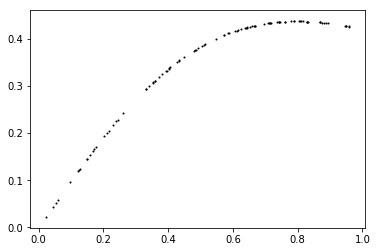

In [44]:
f=lambda x:np.sin(x)/(1+x**2)
x = [np.random.uniform() for i in range(100)]
y = [f(i) for i in x]
plt.scatter(x,y, c='black', s=1)

### Benchmark Errors (MSE only)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


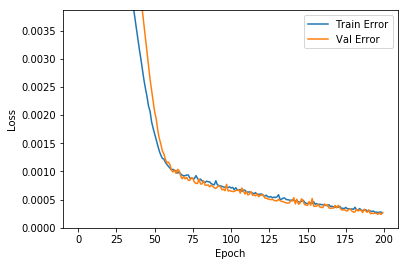

layer 1 weights: [ 0.66708755 -0.67472875  0.36301616 -0.5170068  -0.11619115 -0.25508907
  0.68599635  0.46126708  0.4719096  -0.63711745]
layer 1 bias: 0.021812547, 0.0, 0.020684114, 0.0, 0.0, 0.0, 0.020055981, -0.21966214, -0.22193184, 0.0
layer 2 weights: [0.26170945], [-0.6238113], [0.3955386], [-0.7137592], [0.41041607], [0.5440598], [0.56636417], [-0.706991], [-0.51315], [-0.3200962]
layer 2 bias: 0.019413121

mean of errors: 0.003067363037808337
standard deviation of errors: 0.016161252464079158


In [45]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
  plt.ylim([0,np.max(hist['loss'])/50])
  plt.legend()
  plt.show()
  
def build_model(if_print=False):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(1)])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',optimizer=optimizer)
  if if_print: model.summary()
  return model

def get_data(data_size=10000):
  f=lambda x:np.sin(x)/(1+x**2)
  x = [np.random.uniform() for i in range(data_size)]
  y = [f(i) for i in x]
  return x,y

def get_errors(model, x, y, if_train=False, if_print_weights=False, if_print_errors_stats=False):
  
  if if_train:
    history = model.fit(x, y, epochs=200, validation_split = 0.2, verbose=0)
    plot_history(history)
  
  if if_print_weights:
    print("layer 1 weights:", ', '.join([str(item) for item in model.layers[0].trainable_variables[0].numpy()]))
    print("layer 1 bias:", ', '.join([str(item) for item in model.layers[0].trainable_variables[1].numpy()]))
    print("layer 2 weights:", ', '.join([str(item) for item in model.layers[1].trainable_variables[0].numpy()]))
    print("layer 2 bias:", ', '.join([str(item) for item in model.layers[1].trainable_variables[1].numpy()]))
    
  y_pred = model.predict(x)
  y_pred = y_pred.reshape(-1)
  errors = y - y_pred
  #errors = [np.abs(i) for i in errors]
  mean = np.mean(errors)
  sigma = np.sqrt(np.var(errors))
  if if_print_errors_stats:

    print("\nmean of errors:", mean)
    print("standard deviation of errors:", sigma)
  
  return errors, mean, sigma

model = build_model(1)
x, y = get_data(100)
errors, mean, sigma = get_errors(model, x, y, if_train=1, if_print_weights=1, if_print_errors_stats=1)

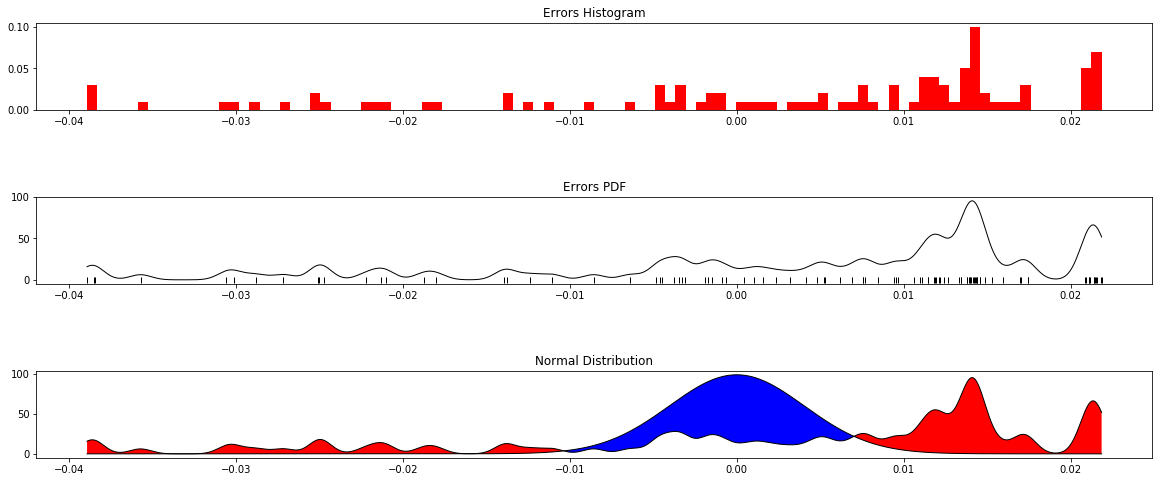

In [46]:
def get_kde(errors):
  kde=stats.gaussian_kde(errors)
  kde.set_bandwidth(bw_method=kde.factor/10)
  return kde
def plot_errors(errors):
  errors_sigma = np.sqrt(np.var(errors))
  plt.figure(figsize=(20, 8))
  plt.xticks(fontsize=10)
  plt.subplots_adjust(hspace=1)

  p1 = plt.subplot(311)
  p1.title.set_text("Errors Histogram")
  weights = np.ones_like(errors)/float(len(errors))
  _, _, _ = plt.hist(errors, weights=weights,bins=100, color='red')

  p2 = plt.subplot(312)
  p2.title.set_text('Errors PDF')

  x1 = np.linspace(np.min(errors), np.max(errors), num=10000)
  kde = get_kde(errors)
  y1 = kde(x1)
  plt.plot(x1, y1, color='black', linewidth=1)
  plt.plot(errors, np.full_like(errors, -0.1), '|k', markeredgewidth=1)

  p3 = plt.subplot(313)
  p3.title.set_text("Normal Distribution")
  y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
  plt.plot(x1, y1, x1, y_norm, color='black', linewidth=1)
  plt.fill_between(x1, y1, y_norm, where=y_norm >= y1, facecolor='blue', interpolate=True)
  plt.fill_between(x1, y1, y_norm, where=y_norm <= y1, facecolor='red', interpolate=True)

plot_errors(errors)

### Benchmark Loss (Target Normal)

Errors Min: -0.038909230915752525 Errors Max: 0.021847904526295092
Crosspoint Index: 4696 and 7558 out of 10000 points

Left crosspoint: -0.010374826671742565 , Right crosspoint: 0.007015604534892125
Area of Normal (between crosspoints): 0.9536366346285728
Area of Errors (between crosspoints): 0.2513985832575992
Loss(Blue area): 0.7022380513709736


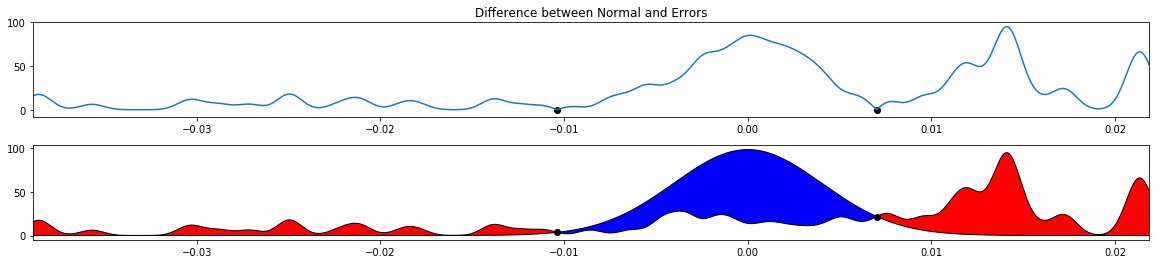

In [47]:
def normal_distribution_function(x,mean,std):
  value = scipy.stats.norm.pdf(x,mean,std)
  return value
  
def kde_function(x, errors):
  kde = get_kde(errors)
  value = kde(x)
  return value
  
def find_nearest(array, value):
  array = np.asarray(array)
  idx = (np.abs(array - value)).argmin()
  return array[idx], idx
  
def get_loss(errors, if_print=False, if_plot=False):
  
  errors_sigma = np.sqrt(np.var(errors))
  x1 = np.linspace(np.min(errors), np.max(errors), num=10000)

  kde = get_kde(errors)
  y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
  y1 = kde(x1)
  idx = np.argwhere(np.diff(np.sign(y_norm - y1))).flatten()
  
  x1_0, x1_0_idx = find_nearest(x1,0)
  crosspoint_1_idx, tmp = find_nearest(idx, x1_0_idx)
  idx = np.delete(idx, tmp, 0)
  crosspoint_2_idx, _ = find_nearest(idx, x1_0_idx)
  crosspoint_1, crosspoint_2 = x1[crosspoint_1_idx], x1[crosspoint_2_idx]
  if crosspoint_1 > crosspoint_2:
    crosspoint_1, crosspoint_2=crosspoint_2, crosspoint_1
    crosspoint_1_idx, crosspoint_2_idx=crosspoint_2_idx, crosspoint_1_idx
    
  norm_area, norm_err = quad(normal_distribution_function, crosspoint_1, crosspoint_2, args=(0,errors_sigma/4,))
  kde_area, kde_err = quad(kde_function, crosspoint_1, crosspoint_2, args=(errors))
  
  if if_print:
    print("Errors Min:", np.min(errors), "Errors Max:", np.max(errors))
    print("Crosspoint Index:", crosspoint_1_idx, "and", crosspoint_2_idx, "out of 10000 points")
    print("\nLeft crosspoint:", crosspoint_1, ", Right crosspoint:", crosspoint_2)
    print("Area of Normal (between crosspoints):", norm_area)
    print("Area of Errors (between crosspoints):", kde_area)
    print("Loss(Blue area):", norm_area-kde_area)
    
  if if_plot:
    plt.figure(figsize=(20, 4))
    plt.xticks(fontsize=10)
    plt.subplots_adjust(hspace=0.3)

    p1 = plt.subplot(211)
    diffs=[np.abs(stats.norm.pdf(i, 0, errors_sigma/4)-kde(i))[0] for i in x1]
    p1.plot(x1, diffs)
    p1.scatter(np.array([crosspoint_1, crosspoint_2]), np.array([diffs[crosspoint_1_idx],diffs[crosspoint_2_idx]]), color="black")
    plt.xlim(np.min(errors), np.max(errors))
    p1.title.set_text("Difference between Normal and Errors")

    p2 = plt.subplot(212)
    y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
    p2.plot(x1, y1, x1, y_norm, color='black', linewidth=1)
    p2.fill_between(x1, y1, y_norm, where=y_norm >= y1, facecolor='blue', interpolate=True)
    p2.fill_between(x1, y1, y_norm, where=y_norm <= y1, facecolor='red', interpolate=True)
    idx1=np.where(crosspoint_1)
    xs = np.array([crosspoint_1, crosspoint_2])
    ys = np.array([y1[crosspoint_1_idx],y1[crosspoint_2_idx]])
    p2.scatter(xs, ys, color="black")
    plt.xlim(np.min(errors), np.max(errors))
    
  return norm_area-kde_area

benchmark_loss = get_loss(errors, if_print=1, if_plot=1)

### Approximate Gradient

In [48]:
def node_plus_delta(layer_n, wb_n, node_n, if_print=False, delta = 10**-6):
  weight_old = model.layers[layer_n].trainable_variables[wb_n].numpy()
  delta_extend = np.zeros(weight_old.shape)
  
  if layer_n == 0:
    if wb_n==0:
      delta_extend[0][node_n] = delta
    elif wb_n==1:
      delta_extend[node_n] = delta
  elif layer_n == 1:
    if wb_n==0:  
      delta_extend[node_n] = delta
    elif wb_n==1:
      delta_extend = delta
      
  weight_new = weight_old + delta_extend
  if if_print: print("\n OLD: model.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  model.layers[layer_n].trainable_variables[wb_n].assign(weight_new)
  if if_print: print("\n NEW: model.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  return weight_old

def node_minus_delta(layer_n, wb_n, node_n, if_print=False, delta = 10**-6):
  weight_old = model.layers[layer_n].trainable_variables[wb_n].numpy()
  delta_extend = np.zeros(weight_old.shape)

  if layer_n == 0:
    if wb_n==0:
      delta_extend[0][node_n] = delta
    elif wb_n==1:
      delta_extend[node_n] = delta
  elif layer_n == 1:
    if wb_n==0:  
      delta_extend[node_n] = delta
    elif wb_n==1:
      delta_extend = delta
    
  weight_new = weight_old - delta_extend
  if if_print: print("\nmodel.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  model.layers[layer_n].trainable_variables[wb_n].assign(weight_new)
  if if_print: print("\nmodel.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  return weight_old

def node_plus_delta_loss(x, y, layer_n, wb_n, node_n, delta_n=1):
  for i in range(delta_n):
    node_plus_delta(layer_n, wb_n, node_n, if_print=0)
  errors, mean, var = get_errors(model, x, y)
  loss = get_loss(errors)
  
  for i in range(delta_n):
    node_minus_delta(layer_n, wb_n, node_n)
  return loss

def check_node_loss(x, y, layer_n, wb_n, node_n):
  node_loss = node_plus_delta_loss(x, y, layer_n, wb_n, node_n)
  delta_n = 1
  n=0
  while benchmark_loss == node_loss and n<10: 
    n+=1
    delta_n+=1
    node_loss = node_plus_delta_loss(x, y, layer_n, wb_n, node_n, delta_n)
  
  if n==10:
    while benchmark_loss == node_loss and n<20: 
      n+=1
      delta_n+=10
      node_loss = node_plus_delta_loss(x, y, layer_n, wb_n, node_n, delta_n)
      
  if n==20:
    while benchmark_loss == node_loss and n<30: 
      n+=1
      delta_n+=100
      node_loss = node_plus_delta_loss(x, y, layer_n, wb_n, node_n, delta_n)
      
  if n==30:
    while benchmark_loss == node_loss and n<40: 
      n+=1
      delta_n+=1000
      node_loss = node_plus_delta_loss(x, y, layer_n, wb_n, node_n, delta_n)
    
  return node_loss, delta_n

def nodes_plus_delta_loss(x, y):
  layer_0_w_losses = []
  layer_0_b_losses = []
  layer_1_w_losses = []
  layer_1_b_losses = []
  
  layer_0_w_delta_n = []
  layer_0_b_delta_n = []
  layer_1_w_delta_n = []
  layer_1_b_delta_n = []
  
  for i in range(10):
    loss, delta_n = check_node_loss(x, y, 0, 0, i)
    layer_0_w_losses.append(loss)
    layer_0_w_delta_n.append(delta_n)
 
  for i in range(10):
    loss, delta_n = check_node_loss(x, y, 0, 1, i)
    layer_0_b_losses.append(loss)
    layer_0_b_delta_n.append(delta_n)
  
  for i in range(10):
    loss, delta_n = check_node_loss(x, y, 1, 0, i)
    layer_1_w_losses.append(loss)
    layer_1_w_delta_n.append(delta_n)
   
  loss, delta_n = check_node_loss(x, y, 1, 1, 0)                                 
  layer_1_b_losses.append(loss)
  layer_1_b_delta_n.append(delta_n)
  
  nodes_losses = [layer_0_w_losses, layer_0_b_losses, layer_1_w_losses, layer_1_b_losses]
  nodes_delta_n = [layer_0_w_delta_n, layer_0_b_delta_n, layer_1_w_delta_n, layer_1_b_delta_n]
  return nodes_losses,nodes_delta_n

nodes_losses, nodes_delta_n = nodes_plus_delta_loss(x, y)
print("benchmark loss:", benchmark_loss)
print("nodes loss:", nodes_losses)
print("nodes_delta_n:", nodes_delta_n)

benchmark loss: 0.7022380513709736
nodes loss: [[0.70223600086182, 0.7022380513709736, 0.7022348246133625, 0.7022380513709736, 0.7022380513709736, 0.7022380513709736, 0.7022336647603348, 0.702240389465005, 0.7022395803213706, 0.7022380513709736], [0.7022331007823301, 0.7022380513709736, 0.7022305929002641, 0.7025200231361292, 0.7019616378562288, 0.7022206985780952, 0.7022275708459422, 0.7022405701639891, 0.7022397885976813, 0.7022380513709736], [0.7022323595847002, 0.7022380513709736, 0.7022348185056031, 0.7022380513709736, 0.7022380513709736, 0.7022380513709736, 0.7022320507855602, 0.7022372939423273, 0.7022373803486086, 0.7022380513709736], [0.7022196251084329]]
nodes_delta_n: [[1, 11111, 1, 11111, 11111, 11111, 1, 1, 1, 11111], [1, 11111, 1, 11111, 3111, 5111, 1, 1, 1, 11111], [1, 11111, 1, 11111, 11111, 11111, 1, 1, 1, 11111], [1]]


In [0]:
def get_gradient(nodes_losses, nodes_delta_n, benchmark_loss):
  gradients = []
  for i in range(len(nodes_losses)):
    grads = []
    for j in range(len(nodes_losses[i])):
      grad = (nodes_losses[i][j])/(nodes_delta_n[i][j]**10**-6)
      grads.append(grad)
    gradients.append(grads)
    
  return gradients

grads = get_gradient(nodes_losses, nodes_delta_n, benchmark_loss)

In [51]:
print(grads)

[[0.70223600086182, 0.7022315095688282, 0.7022348246133625, 0.7022315095688282, 0.7022315095688282, 0.7022315095688282, 0.7022336647603348, 0.702240389465005, 0.7022395803213706, 0.7022315095688282], [0.7022331007823301, 0.7022315095688282, 0.7022305929002641, 0.7025134787072342, 0.7019559922124203, 0.7022147022355669, 0.7022275708459422, 0.7022405701639891, 0.7022397885976813, 0.7022315095688282], [0.7022323595847002, 0.7022315095688282, 0.7022348185056031, 0.7022315095688282, 0.7022315095688282, 0.7022315095688282, 0.7022320507855602, 0.7022372939423273, 0.7022373803486086, 0.7022315095688282], [0.7022196251084329]]


In [50]:
def update_nodes(model, grads, nodes_delta_n, if_print = False):
  if if_print: 
    print("\n OLD:")
    print("model.layers[0].trainable_variables[0]:", model.layers[0].trainable_variables[0])
    print("model.layers[0].trainable_variables[1]:", model.layers[0].trainable_variables[1])
    print("model.layers[1].trainable_variables[0]:", model.layers[1].trainable_variables[0])
    print("model.layers[1].trainable_variables[1]:", model.layers[1].trainable_variables[1])
  for i in range(len(grads)):
    for j in range(len(grads[i])):
      lr = nodes_delta_n[i][j]**10**-6
      delta = lr*grads[i][j]
      node_plus_delta(layer_n=0 if i<2 else 1, wb_n=i%2, node_n=j, delta = -delta)
      
  if if_print: 
    print("\n NEW:")
    print("model.layers[0].trainable_variables[0]:", model.layers[0].trainable_variables[0])
    print("model.layers[0].trainable_variables[1]:", model.layers[0].trainable_variables[1])
    print("model.layers[1].trainable_variables[0]:", model.layers[1].trainable_variables[0])
    print("model.layers[1].trainable_variables[1]:", model.layers[1].trainable_variables[1])
    
  return model

model=update_nodes(model, grads, nodes_delta_n, if_print=1)


 OLD:
model.layers[0].trainable_variables[0]: <tf.Variable 'dense_10/kernel:0' shape=(1, 10) dtype=float32, numpy=
array([[ 0.66708755, -0.67472875,  0.36301616, -0.5170068 , -0.11619115,
        -0.25508907,  0.68599635,  0.46126708,  0.4719096 , -0.63711745]],
      dtype=float32)>
model.layers[0].trainable_variables[1]: <tf.Variable 'dense_10/bias:0' shape=(10,) dtype=float32, numpy=
array([ 2.18125470e-02,  1.12092696e-10,  2.06841137e-02,  1.12092696e-10,
       -1.20737947e-10, -3.53568591e-10,  2.00559814e-02, -2.19662145e-01,
       -2.21931845e-01,  1.12092696e-10], dtype=float32)>
model.layers[1].trainable_variables[0]: <tf.Variable 'dense_11/kernel:0' shape=(10, 1) dtype=float32, numpy=
array([[ 0.26170945],
       [-0.6238113 ],
       [ 0.3955386 ],
       [-0.7137592 ],
       [ 0.41041607],
       [ 0.5440598 ],
       [ 0.56636417],
       [-0.706991  ],
       [-0.51315   ],
       [-0.3200962 ]], dtype=float32)>
model.layers[1].trainable_variables[1]: <tf.Variable 'd

In [0]:
errors, mean, sigma = get_errors(model, x, y, if_train=0, if_print_weights=1, if_print_errors_stats=1)
new_loss = get_loss(errors, if_print=1, if_plot=1)

In [23]:
print("benchmark loss:", benchmark_loss)
print("layer[", layer_n, "]-wb_n[", wb_n, "]-node_n[", node_n, "] with delta as", delta_n*10**-6, ":",node_loss)

benchmark loss: 0.652872751824916
layer[ 1 ]-wb_n[ 1 ]-node_n[ 1 ] with delta as 1e-06 : 0.6528740185436295


In [39]:
model.layers[0].trainable_variables[1]

<tf.Variable 'dense_8/bias:0' shape=(10,) dtype=float32, numpy=
array([ 2.4291739e-02, -9.2258281e-04, -4.3226247e-12, -1.7412025e-01,
        1.9998793e-06, -2.8993186e-01,  2.8944902e-02, -1.2073795e-10,
       -2.7840745e-01,  2.4246221e-02], dtype=float32)>

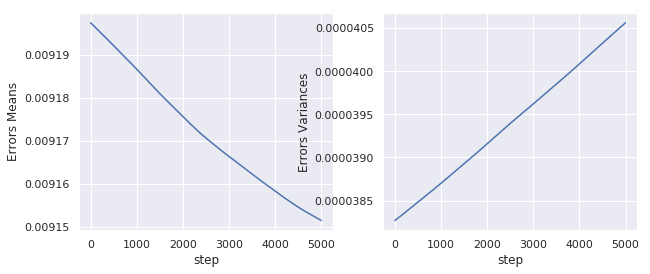

In [509]:
#delta_w = sys.float_info.min*10**302
def weights_plus_delta(layer_n, wb_n_n, if_print=False, delta = 10**-7):
  if if_print:
    print("------------------------------------------------------------")
    print("ΔW:", delta)
    print("\nOld weights of layer",layer_n, ", nodes", node_n, ":", model.layers[layer_n].trainable_variables[node_n])
  model.layers[layer_n].trainable_variables[node_n].assign(model.layers[layer_n].trainable_variables[node_n]+delta)
  if if_print:
    print("\nNew weights of layer",layer_n, ", nodes", node_n, ":", model.layers[layer_n].trainable_variables[node_n])
    
def model_plus_delta(): 
  weights_plus_delta(0,0, if_print=0)
  weights_plus_delta(0,1)
  weights_plus_delta(1,0)
  weights_plus_delta(0,1)

def fumble(x, y, steps = 5000, if_earlystop=True, if_plot=False):
  means = []
  variances = []
  mean_min = 1
  patience_n = 20
  patience = patience_n
  for i in range(steps):
    model_plus_delta()
    errors, mean_, var_ = get_errors(model, x, y, if_train=0)
    errors = [np.abs(e) for e in errors]
    mean = np.mean(errors)
    var = np.var(errors)
    means.append(mean)
    variances.append(var)

    if i>0:
      if mean >= means[-2]:
        patience = patience-1
        if patience<=0: break
      else:
        patience = patience_n
    
  if if_plot:  
    x = np.arange(len(means))
    
    plt.figure(figsize=(10, 4))
    plt.xticks(fontsize=10)
    plt.subplots_adjust(hspace=0.3)

    p1 = plt.subplot(121)
    p1.plot(x, means)
    plt.xlabel("step")
    plt.ylabel("Errors Means")
    
    p2 = plt.subplot(122)
    p2.plot(x, variances)
    plt.xlabel("step")
    plt.ylabel("Errors Variances")
    
  return means, variances

means, variances = fumble(x, y, if_plot=1)